In [6]:
import tensorflow as tf
from pathlib import Path
import numpy as np
from load_utils import load_4classes, load_shipsear

In [4]:
data = load_4classes()

In [4]:
def tile_dataset(tile_size, hop, data):
    tiled_sxx = list()
    for sxx in data:
        size = sxx.shape[0]
        run = list()
        for i in range(0, size-tile_size, (tile_size - hop)):
            run.append(sxx[i:(i+tile_size), (sxx.shape[1]-hop):, :].astype(np.float32))
        tiled_sxx.append(np.stack(run, axis=0))
    return tiled_sxx
tiled_data = tile_dataset(h, 21, data)

NameError: name 'h' is not defined

In [11]:
len(

6

In [16]:
dset_4classes = tf.data.Dataset.from_tensor_slices(tiled_data[0]).shuffle(100)



<tf.Tensor: shape=(143, 533, 1), dtype=float32, numpy=
array([[[ 0.        ],
        [ 0.44667968],
        [ 6.911211  ],
        ...,
        [ 0.        ],
        [-2.1128604 ],
        [-1.522324  ]],

       [[-0.19211252],
        [ 2.2472353 ],
        [ 5.719     ],
        ...,
        [-0.9959625 ],
        [ 3.8838904 ],
        [-0.94691133]],

       [[-0.6216531 ],
        [ 2.9542987 ],
        [ 1.6878495 ],
        ...,
        [-0.17131896],
        [ 2.981926  ],
        [ 0.        ]],

       ...,

       [[-1.405927  ],
        [ 4.5123916 ],
        [ 3.6083636 ],
        ...,
        [ 0.        ],
        [ 0.06574653],
        [ 0.        ]],

       [[ 1.3683777 ],
        [ 1.9403669 ],
        [-0.48942876],
        ...,
        [ 6.9144163 ],
        [ 4.0356464 ],
        [ 1.7911975 ]],

       [[ 0.        ],
        [ 1.5518451 ],
        [ 0.        ],
        ...,
        [ 0.        ],
        [-3.3393903 ],
        [ 0.        ]]], dtype=float32)

In [7]:
data = np.load(Path('generated_samples') / "train" /  '000.npz')
h, w, c = data["arr_0"].shape

In [8]:
h

143

In [14]:
import numpy as np
import scipy
from sklearn.preprocessing import LabelEncoder

import sys
sys.path.append('../../')

from src.data.offline import load_raw_data
from torch.utils.data import Dataset

time_data = load_raw_data('./../../acoustic_lane/4classes', run_pattern=r'[0-9]+$')

from pathlib import Path

In [ ]:
from modified_lofar import lofar

sxxs = list()
for data in time_data:
    sxx, freq, time = lofar(data.data, sr=data.sr, final_sr=7350, use_tpsw=True, tonal_threshold=-4)
    sxxs.append(sxx)
    
sxxs

In [17]:
import tensorflow as tf
from unet import custom_objects
reconstructed_model = tf.keras.models.load_model("unet_lofar_run_1_back", custom_objects=custom_objects)

In [9]:
reconstructed_model

In [10]:
reconstructed_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, None, None, 1 2480        inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 1 0           conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, None, None, 3 13888       max_pooling2d[0][0]              
_______________________________________________________________________________________________

In [11]:
gen_samples_path = Path("generated_samples")
def load_images(gen_samples_path, mode):
    def gen_img():
        for file in list((gen_samples_path / mode).iterdir()):
            data = np.load(file)
            
            yield data["arr_0"].astype(np.float32), data["arr_1"].astype(np.float32)
    return gen_img
#train_dataset = tf.data.Dataset.list_files(str(gen_samples_path / "train" / "*.npz"), shuffle=True)

train_dataset = tf.data.Dataset.from_generator(load_images(gen_samples_path, "train"), 
                                               output_signature= (tf.TensorSpec((h, w, c), dtype=tf.float32), 
                                                                  tf.TensorSpec((h, w, 2), dtype=tf.float32)))
validation_dataset = tf.data.Dataset.from_generator(load_images(gen_samples_path, "validation"), 
                                               output_signature= (tf.TensorSpec((h, w, c), dtype=tf.float32), 
                                                                  tf.TensorSpec((h, w, 2), dtype=tf.float32)))



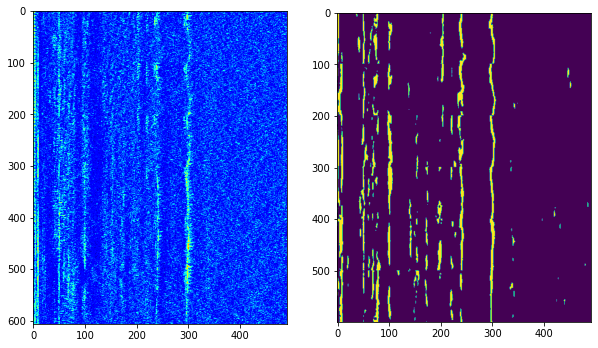

In [114]:
import matplotlib.pyplot as plt
dset_4classes = tf.data.Dataset.from_tensor_slices(tiled_data[1])
#reconstructed_model.evaluate(train_dataset.take(1))
run_pred = list()
original_image = list()
for sample in list(dset_4classes):
    prediction = reconstructed_model.predict(sample[None, ...])
    original_image.append(sample[21:(sample.shape[0]-21), 21:(sample.shape[1] - 21)])
    prediction = prediction[0, :, :, 0]
    p = .70
    prediction[prediction[:, :] > p] = 1
    prediction[prediction[:, :] <= p] = 0
    run_pred.append(prediction[:, :])#.argmax(axis=-1).astype(bool))
original_image = np.concatenate(original_image, axis=0)
run_pred = np.concatenate(run_pred, axis=0)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,10))
ax1.imshow(original_image, cmap="jet")
ax2.imshow(run_pred)

In [7]:
from unet.callbacks import TensorBoardImageSummary
log_dir_path = "unet_lofar_run_1"
tb_img = TensorBoardImageSummary("validation", logdir=log_dir_path, dataset=validation_dataset, max_outputs=10)

In [30]:
import unet
from unet.datasets import circles

#building the model
# unet_model = unet.build_model(channels=c,
#                               num_classes=2,
#                               layer_depth=2,
#                               filters_root=16)

# unet.finalize_model(unet_model)

#training and validating the model
trainer = unet.Trainer(name="unet_gen_test", log_dir_path ="unet_lofar_run_1", checkpoint_callback =True, tensorboard_callback=True)#, tensorboard_images_callback=tb_img)
trainer.evaluate(reconstructed_model, train_dataset.take(1))
#trainer.fit(unet_model,
#           train_dataset,
#           validation_dataset,
#           epochs=10,
#           batch_size=64)

TypeError: in user code:

    /home/pedro/miniconda3/lib/python3.8/site-packages/unet/utils.py:33 crop  *
        return image, crop_to_shape(label, shape)
    /home/pedro/miniconda3/lib/python3.8/site-packages/unet/utils.py:13 crop_to_shape  *
        diff_nx = (data.shape[0] - shape[0])

    TypeError: 'NoneType' object is not subscriptable


In [ ]:
x = list(train_dataset.take(1))

In [51]:
a, b = x[0]

In [52]:
unet_model(a[None, :, :, :]).shape

TensorShape([1, 64, 472, 2])

In [54]:
(107-64)//2

21

In [48]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
dataset = dataset.map(lambda x: x*2)
dataset = dataset.map(lambda x: x*2)
list(dataset.as_numpy_iterator())


[4, 8, 12]